# test icewebSpectrogram

Test the Python version of IceWeb. Under development.

Last update: Glenn Thompson 2021/06/21

Processing 2005-05-01-0149-37S.MVO___025
- writing HTML/MVOE_/2005/05/2005-05-01-0149-37S.MVO___025_raw.mseed
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Outliers: 0
(100, 91)
(91,)
Processing 2005-05-01-0412-49S.MVO___025
- reading 2005-05-01-0412-49S.MVO___025
- writing HTML/MVOE_/2005/05/2005-05-01-0412-49S.MVO___025_raw.mseed
Outliers: 0
(100, 89)
(89,)
Outliers: 0
(100, 89)
(89,)
Outliers: 0
(100, 89)
(89,)
Outliers: 0
(100, 89)
(89,)
Outliers: 0
(100, 89)
(89,)
Outliers: 0
(100, 89)
(89,)
Outliers: 0


NameError: name 'pd' is not defined

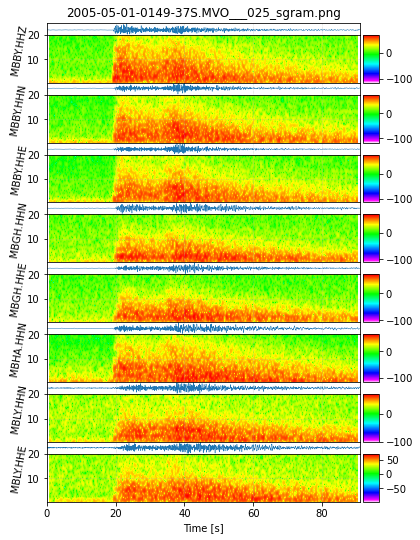

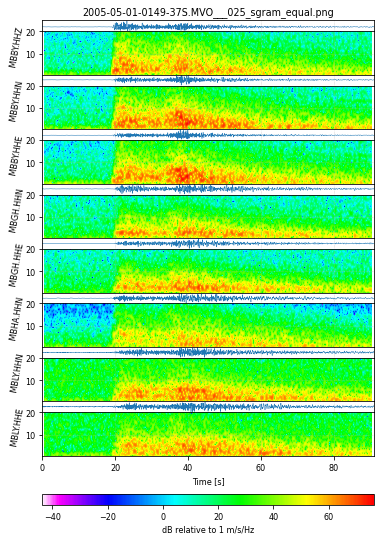

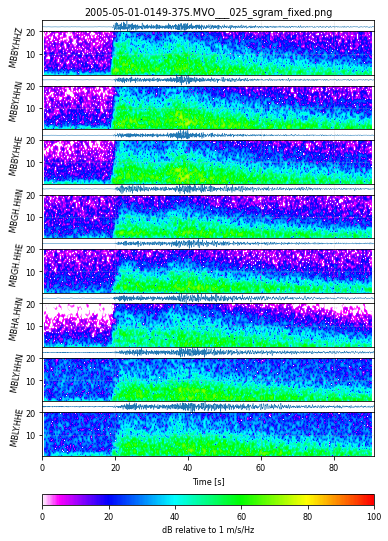

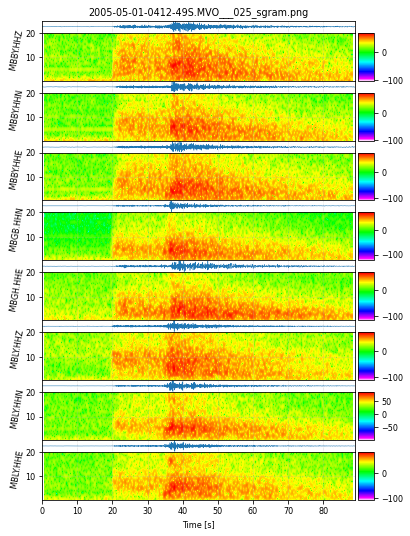

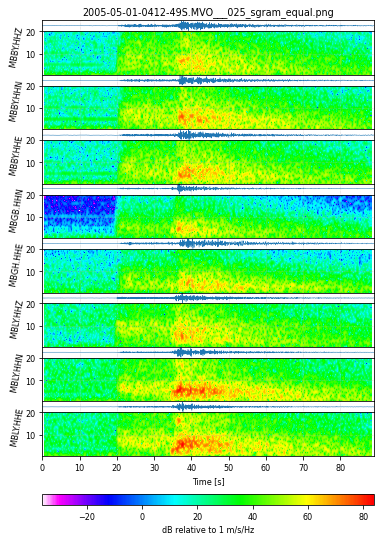

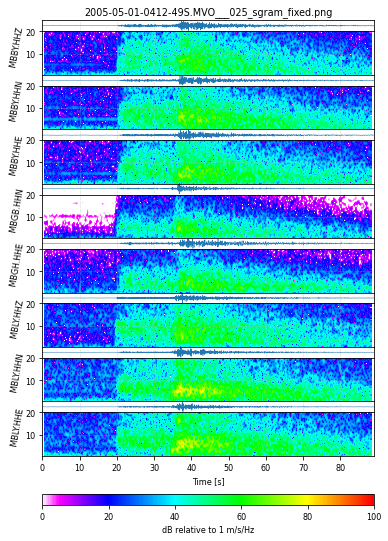

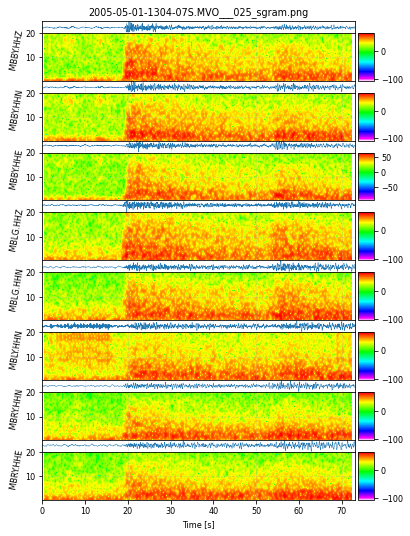

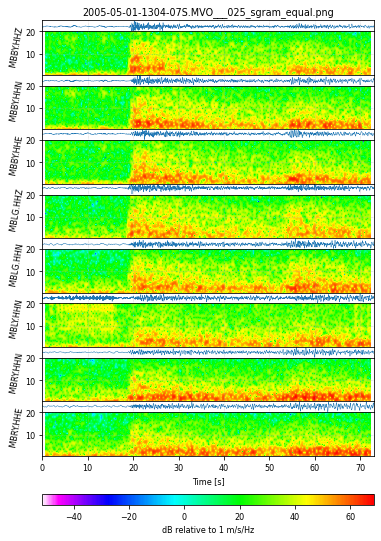

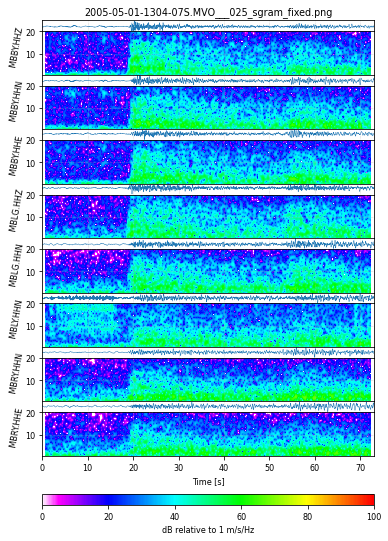

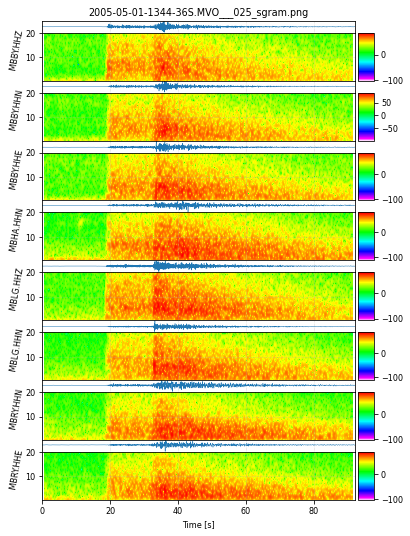

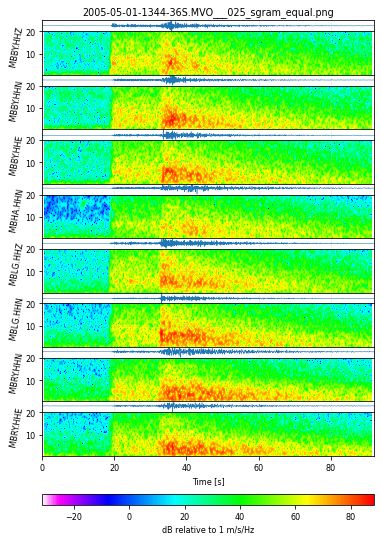

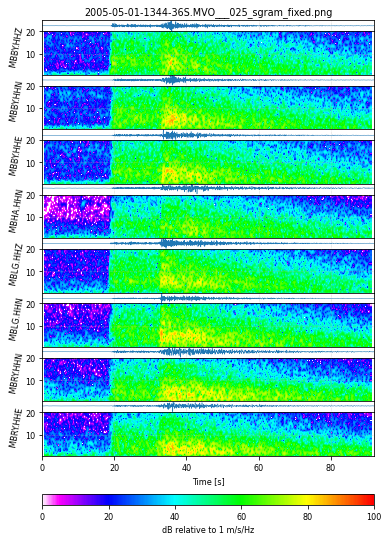

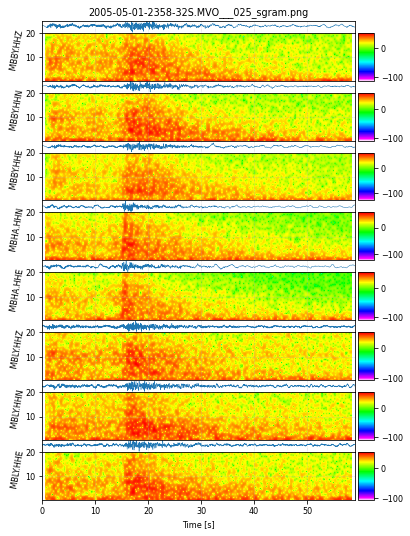

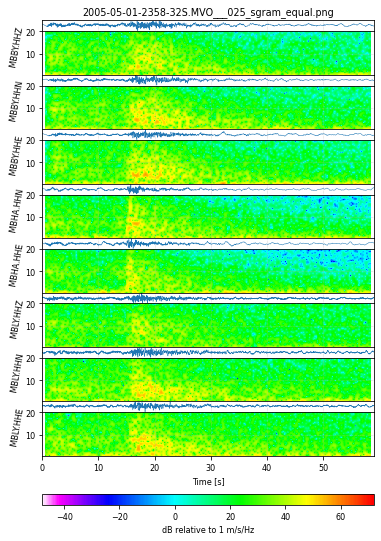

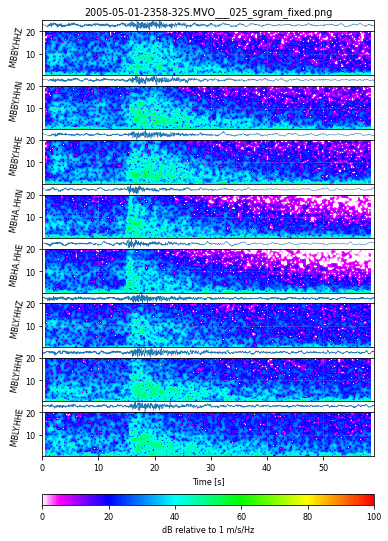

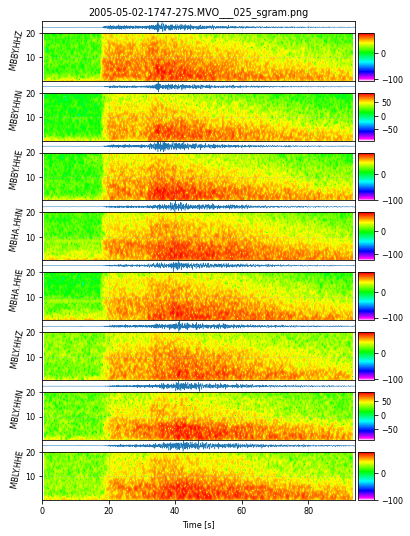

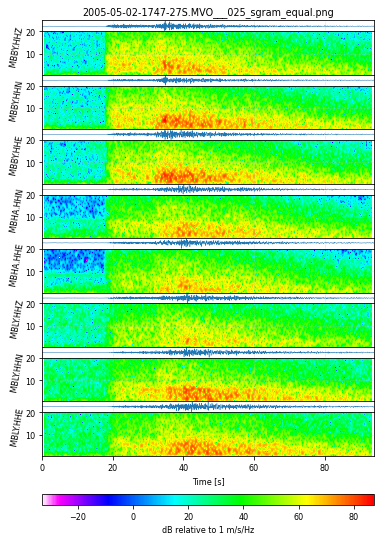

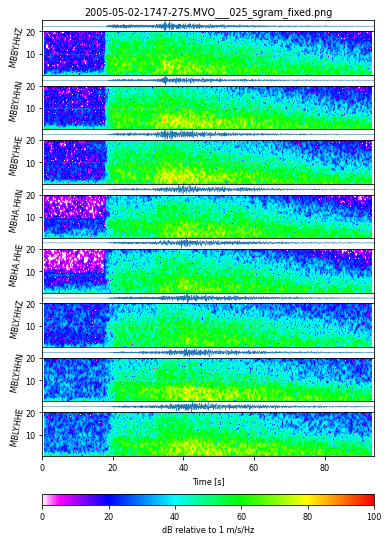

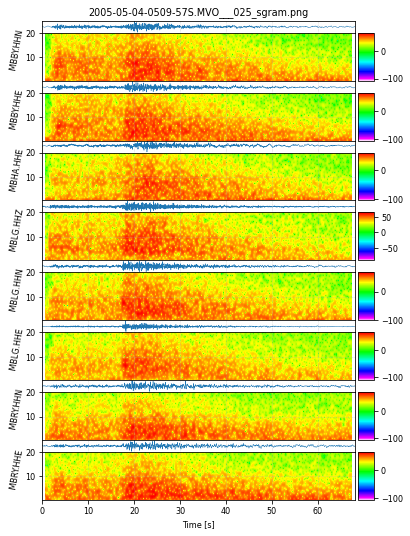

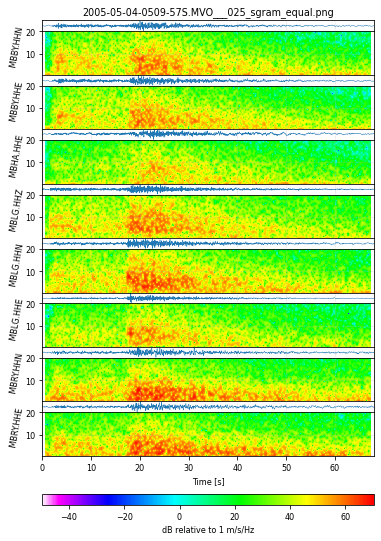

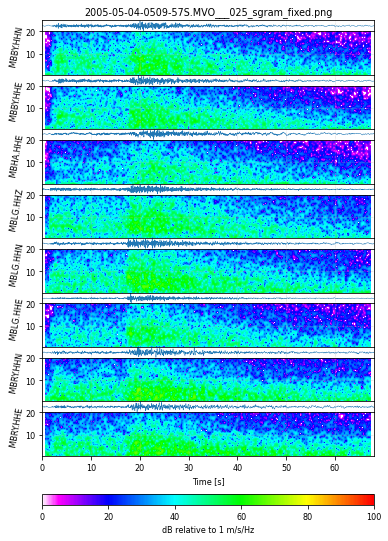

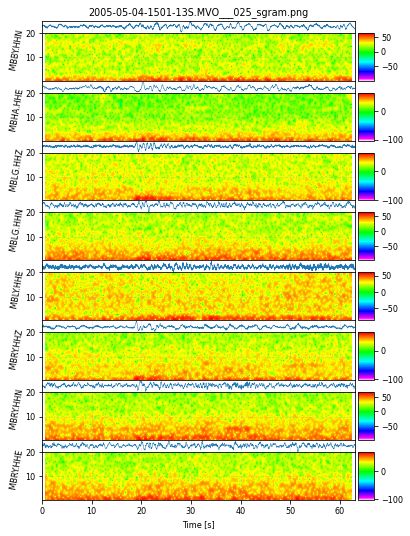

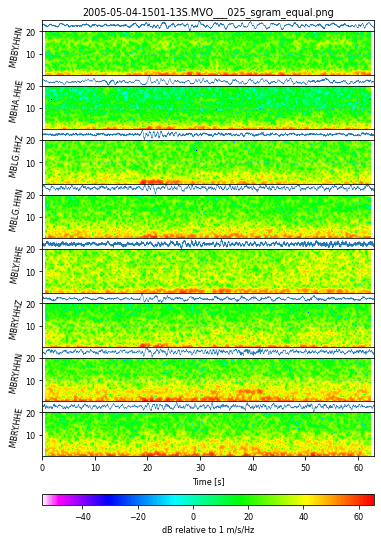

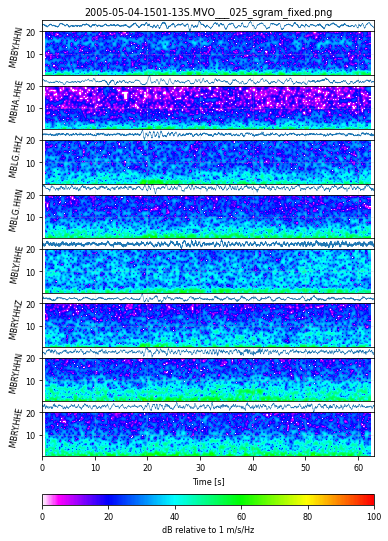

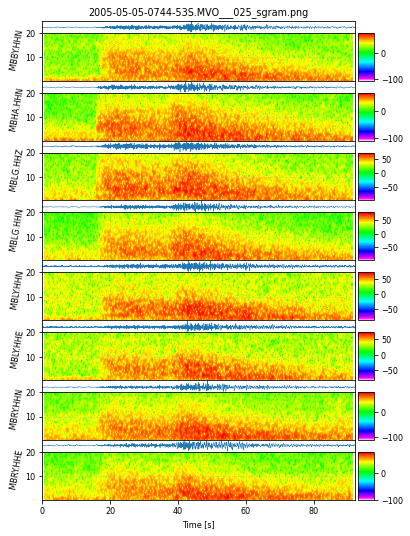

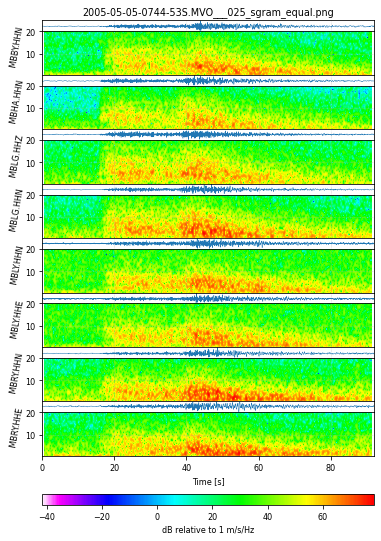

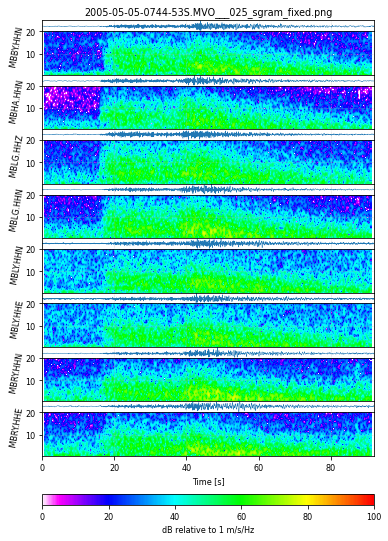

In [1]:
""" 
We are working here from the WAV files in Seisan. 
We ideally need a process that checks for REA files that exist without corresponding WAV files too.

Plus we might want to build a version of this from an Antelope catalog.
"""

# st.select(): A new Stream object is returned but 
# the traces it contains are just aliases to the traces of the original stream. 
# Does not copy the data but only passes a reference.
# So I guess if you change a trace, it changes the same way in both streams! Dangerous!
# So think of Stream as just a container for Trace objects and each Stream can references same Traces.

import os, sys
import numpy as np
from obspy import read, read_inventory, Stream
from obspy.io.xseed.core import _read_resp
#from obspy.signal.freqattributes import spectrum
from obspy.imaging.cm import obspy_sequential


sys.path.append('/Users/thompsong/src/kitchensinkGT/LIB')
#import libseisGT
from libMVO import fix_trace_id #correct_nslc
from metrics import process_trace, choose_best_traces, select_by_index_list

sys.path.append('/Users/thompsong/src/icewebPy')
import IceWeb

            
def create_event_picklefiles(DB, YYYY, MM, shortperiod, MAX_FILES_TO_PROCESS=999999):
    eventdir = os.path.join('WAV', DB, YYYY, MM)
    badseisanfiles = []
    pngdir = eventdir.replace('WAV', 'HTML')
    pickledir = eventdir.replace('WAV', 'PICKLE')
    num_files_processed = 0
    if not os.path.exists(pngdir):
        os.makedirs(pngdir)
    if not os.path.exists(pickledir):
        os.makedirs(pickledir)        
    for root, dirs, files in os.walk(eventdir, topdown=False):
        files = sorted(files)
        for seisanfile in files:
            
            if num_files_processed >= MAX_FILES_TO_PROCESS:
                print('Have reached MAX_FILES_TO_PROCESS limit')
                break
            
            print('Processing %s' % seisanfile)
            st = Stream()
            
            # check for non-seisan files
            if seisanfile[-4:]=='.png':
                #os.remove(thisfile)
                continue
            if not (seisanfile[0:2]=='19' or seisanfile[0:2]=='20'):
                print('Unrecognized file: %s' % seisanfile)
                continue
                
            
                
            seisanfullpath = os.path.join(root, seisanfile)    
            rawpngfile = os.path.join(pngdir, seisanfile + '_raw.png')
            correctedpngfile = rawpngfile.replace('_raw', '_corrected')
            rawmseedfile = rawpngfile.replace('.png', '.mseed')
            #correctedmseedfile = correctedpngfile.replace('.png', '.mseed')
            picklefile = correctedpngfile.replace('_corrected.png', '.pickle').replace('HTML', 'PICKLE')

            if os.path.exists(picklefile):
                continue
            
            if os.path.exists(rawmseedfile):
                #pass
                st = read(rawmseedfile)
            else:
                try:
                    print('- reading %s' % seisanfile)
                    st = read(seisanfullpath)        
                except:
                    badseisanfiles.append(seisanfile)
            
            #print(st)
            if len(st)==0:
                print('No traces loaded')
                continue

            # write raw Miniseed file and create plot of Z-components only
            print('- writing %s' % rawmseedfile)
            st.write(rawmseedfile)
            st.plot(equal_scale=False, outfile=rawpngfile, dpi=100); 

            for tr in st:
                                    
                ## find inventory
                this_inv = None
                tr.stats.network = 'MN' # temporary, to match RESP files, should be 'MV'
                respfile = os.path.join('CAL', "RESP.%s" % tr.id)
                xmlfile = os.path.join(pngdir, "inventory.%s.xml" % tr.id)
                #print('StationXML file = ',xmlfile)
                if os.path.exists(xmlfile):
                    this_inv = read_inventory(xmlfile)
                elif os.path.exists(respfile):
                    print('RESP file = ',respfile)
                    this_inv = _read_resp(respfile)
                    this_inv.write(xmlfile , format="STATIONXML")
                #print(this_inv)
                
                # data QC and clean (detrend, filter and correct) trace
                process_trace(tr, inv=this_inv)
                if tr.stats.quality_factor <= 0:
                    st.remove(tr)
                    continue
                    
                if 'calibrated' in tr.stats.history or 'deconvolved' in tr.stats.history:
                    tr.stats.quality_factor *= 10                   
                
                # fix trace ID
                #tr.id = correct_nslc(tr.id, tr.stats.sampling_rate, shortperiod=shortperiod)
                
                
                #print(tr.stats)
                #print('-- %s, trace quality = %d' % (tr.id, tr.stats.quality_factor))

            fix_trace_id(st, shortperiod=shortperiod)
            
            # WRITE A PICKLE FILE HERE
            st.write(picklefile, format='PICKLE')
            num_files_processed += 1
            
            #stZ = st.select(component='Z')
            #stZ.plot(equal_scale=True, outfile=correctedpngfile)
            chosen = choose_best_traces(st, MAX_TRACES=20)
            st2 = select_by_index_list(st, chosen)
            st2.plot(equal_scale=True, outfile=correctedpngfile)
            
            # need a separate plot for any infrasound channels
            
    return badseisanfiles

                
def create_event_spectrograms(DB, YYYY, MM):                       

    eventdir = os.path.join('PICKLE', DB, YYYY, MM)
    
    for root, dirs, files in os.walk(eventdir, topdown=False):
        files = sorted(files)
        for file in files:
            if not '.pickle' in file:
                continue
                
            print('Processing %s' % file)
            picklefullpath = os.path.join(root, file) 
            st = read(picklefullpath)
            #print(st)
      
            iwsobj = IceWeb.icewebSpectrogram(stream=st)
            iwsobj = iwsobj.precompute()
     
            # free scale
            sgramfile = picklefullpath.replace('.pickle', '_sgram.png').replace('PICKLE', 'HTML')   
            print('Creating ',sgramfile)            
            titlestr = os.path.basename(sgramfile) 
            chosen = choose_best_traces(st, MAX_TRACES=10)            
            iwsobj.plot(outfile=sgramfile, log=False, equal_scale=False, add_colorbar=True, dbscale=True, title=titlestr, trace_indexes=chosen)

            
            # equal scale
            sgramequal = picklefullpath.replace('.pickle', '_sgram_equal.png').replace('PICKLE', 'HTML')            
            titlestr = os.path.basename(sgramequal)           
            iwsobj.plot(outfile=sgramequal, log=False, equal_scale=True, add_colorbar=True, dbscale=True, title=titlestr, trace_indexes=chosen)
                        
            
            # fixed scale
            sgramfixed = picklefullpath.replace('.pickle', '_sgram_fixed.png').replace('PICKLE', 'HTML')            
            titlestr = os.path.basename(sgramfixed)
            clim_in_dB = [0, 100]
            clim_in_units = [ IceWeb.dB2amp(clim_in_dB[0]),  IceWeb.dB2amp(clim_in_dB[1]) ]
            iwsobj.plot(outfile=sgramfixed, log=False, clim=clim_in_units, add_colorbar=True, dbscale=True, title=titlestr, trace_indexes=chosen)

            # could record data to make ESAM/event spectrograms later
            # an alternative version might be to plot the sum of spectral data by event type per day,
            # then plot those sums as an event spectrogram - against a daily sampling rate.
            # 
            # from either version could then pick the biggest events
            
            # need separate plots for any infrasound channels
                       
def more_aef():
    
    eventdir = os.path.join('PICKLE', DB, YYYY, MM)
    
    for root, dirs, files in os.walk(eventdir, topdown=False):
        files = sorted(files)
        for file in files:
            if not '.pickle' in file:
                continue
                
            """
            # add an ampengfft method to IceWeb.icewebSpectrogram and modify iwsobj.stream
            # but rather than just replicate old ampengfft which was more like ampengssam,
            # probably better to return full FFT, just as in frequency metrics sampled once-per-minute in GISMO/+iceweb
            # The easy way to do it for events or 10-min or 20-min continuous data chunks is probably:
            1. iwsobj = IceWeb.icewebSpectrogram(st)
            2. iwsobj = iwsobj.precompute()
            3. aef = ampengfft(iwsobj)
            aef here would be a list of dictionaries, one per Trace
            each dict would contain maxamp, energy, ampspec
            do we want to break these down for each minute, for both event and continuous data?
            
            let's also add method for instrument corrected RSAM from my course or the White Island project
            check Miami Lakes too
            Do I also want to archive SSAM?
            """          
            # ampengfft - need to figure best model for this out
            #iwsobj.ampengfft()             

            if not aef:
                continue
        
            ampengfft(iwsobj)
        
            # write an AEF-file
            fptr = open(aeffile, 'w')
            fptr.write('NSLC, amp, eng, f0-1, f1-2, f2-3, f3-4, f4-5, f5-6, f6-7, f7-8, f8-9, f9-10, f10-11, f11-12, f12-13, f13-14, f14-15, f15-16\n')
            for tr in st:
                fptr.write('%s, %4.2e, %4.2e' % (tr.id, tr.stats.peakamp, tr.stats.energy))
                if 'ssam' in tr.stats:
                    for x in tr.stats.ssam:
                        fptr.write(', %4.2e' % (x/tr.stats.peakamp))
                fptr.write('\n')
            fptr.close()

def create_event_website(DB, YYYY, MM):                       

    eventdir = os.path.join('HTML', DB, YYYY, MM)
    allsgramfiles = []
    allseismograms = []
    allwebpages = []
    
    for root, dirs, files in os.walk(eventdir, topdown=False):
        files = sorted(files)
        for file in files:
            if not '_sgram.png' in file:
                continue
                
            print('Processing %s' % file)
            sgramfullpath = os.path.join(root, file) 
            allsgramfiles.append(sgramfullpath)
            htmlfile = sgramfullpath.replace('_sgram.png','.html')
            allwebpages.append(htmlfile) # need this for previous and next links
            
    for c, sgramfile in enumerate(allsgramfiles):
        seismogramfile = sgramfullpath.replace('_sgram','_corrected')
        csvfile = sgramfullpath.replace('_sgram.png','.csv').replace('HTML', 'PICKLE')
        build_event_webpage(allwebpages, c, streamplot=seismogramfile, sgramplot=sgramfile, csv=csvfile)
    

def build_event_webpage(allwebpages, c, streamdf=None, streamplot=None, sgramplot=None, csv=None):
    # put Python code inside % tags, e.g. <% for i in range(10): %>
    
    htmlfile = allwebpages[c]
    lastwebpage = None
    nextwebpage = None
    ind = allwebpages.index(htmlfile)
    if ind>0:
        lastwebpage = allwebpages[ind-1]
    if ind<len(allwebpages)-2:
        nextwebpage = allwebpages[ind+1]
    
    html = """
    <html>
    <head>
    <title>Event webpage</title>
    </head>
    <body>
    <h1>
    """
    html += "%s" % os.path.basename(htmlfile)[0:17]
    
    html += """
    </h1>
    <table border=1>
    <tr>
    """ 
    
    if lastwebpage:
        html += "<td><a href=\"%s\">Previous</a></td>" % os.path.basename(lastwebpage)
    if csv:
        if os.path.exists(csv):
            pass      
        
    html += "<td>"   
    
        
    if sgramplot:
        sgrambase = os.path.basename(sgramplot)
        html += "<h2>Individually scaled</h2><br/><img src=\"%s\"><br/>"% os.path.basename(sgramplot)

        sgramplot_equal = sgramplot.replace('.png','_equal.png')
        if os.path.exists(sgramplot_equal):
            html += "<h2>Equally scaled</h2><br/><img src=\"%s\"><br/>"% os.path.basename(sgramplot_equal)        
        
        sgramplot_fixed = sgramplot.replace('.png','_fixed.png')
        if os.path.exists(sgramplot_fixed):
            html += "<h2>Fixed scale</h2><br/><img src=\"%s\"><br/>"% os.path.basename(sgramplot_fixed)

        
    html += "</td>"         
    
    if nextwebpage:
        html += "<td><a href=\"%s\">Next</a></td>" % os.path.basename(nextwebpage)
        
    html += "</tr>"

    
    if streamplot:
        html += "<tr><td colspan=\"3\"><img src=\"%s\"></td></tr>" % os.path.basename(streamplot)        
                
    html += """
    </table>
    </body>
    </html>
    """    

    #print(html)
    
    # Write HTML String to file.html
    fptr = open(htmlfile, "w")
    fptr.write(html)
    fptr.close()    
    
    
def pickle2csv(DB, YYYY, MM, MAX_FILES_TO_PROCESS=999999):
    # what metrics do we put into dataframe here. spectraldata. 
    # we want to add any metadata to print on webpages
    # write csvfile replace('.pickle','.csv')                      

    eventdir = os.path.join('PICKLE', DB, YYYY, MM)
    num_files_processed = 0
       
    for root, dirs, files in os.walk(eventdir, topdown=False):
        files = sorted(files)
        for file in files:        
            if num_files_processed >= MAX_FILES_TO_PROCESS:
                print('Have reached MAX_FILES_TO_PROCESS limit')
                break

            if not '.pickle' in file:
                continue
                
            print('Processing %s' % file)
            picklefullpath = os.path.join(root, file) 
            st = read(picklefullpath)
            df = pd.DataFrame()
            list_of_rows = []
            for tr in st:
                s = tr.stats
                m = s.metrics
                row = {'id':id, 'starttime':m['start_time'], 'sampling_rate':s.sampling_rate, 'duration':s.duration, }
                print(tr.id)
            
            num_files_processed += 1

# Montserrat Seisan data processor, one month at a time
os.chdir('%s/DATA/MVO' % os.getenv('HOME'))
DB = 'MVOE_'
YYYY = '2005'
MM = '05'
shortperiod = False
if DB[0:4]=='ASNE':
    shortperiod = True
badseisanfiles = create_event_picklefiles(DB, YYYY, MM, shortperiod, MAX_FILES_TO_PROCESS=9)
#print('\nBad Seisan files:')
#print(badseisanfiles)
#print("\n")
create_event_spectrograms(DB, YYYY, MM)
create_event_website(DB, YYYY, MM)
pickle2csv(DB, YYYY, MM, MAX_FILES_TO_PROCESS=3)